<h1> <a> Apprentissage </a> </h1>
<h2> Pour le Challenge Axa </h2>
<h3> Axa Graduate Program Février 2017 </h3>
<i> Author : Paul Tran </i> <br>


--------------

# Sommaire
1. [Préliminaires](#préliminaires)
    1. [Introduction](#introduction)
    2. [Imports](#imports)
    3. [Chargement de la donnée](#load)
2. [Data Management](#management)
    1. [Train, Validation & Test](#split)
    2. [Description de la donnée](#description)
3. [Machine Learning](#ML)
    1. [Méthode Linéaire](#linéaire)
        1. [Régression Linéaire simple](#RF)
        2. [Lasso](#ET)
    2. [Méthodes ensemblistes](#ensemblistes)
        1. [Random Forest](#RF)
        2. [Extra Trees](#ET)
        3. [XG Boost](#XGB)
4. [Interprétation des modèles](#interprétation)
5. [Soumission des résultats](#submit)

------------

# Préliminaires  <a name="préiliminaires"></a>

- ## Introduction :  <a name="introduction"></a>

Dans cette partie nous allons gérer l'approche naïve de l'apprentissage avec très peu de modifications sur la donnée. Nous tenterons par la suite d'effectuer un travail plus réfléchi sur la donnée dans l'optique d'obtenir un meilleur score.

- ## Précautions

Ce notebook prend beaucoup de temps à être exécuté dans son intégralité du fait des apprentissages successifs qui sont lancés. Il est conseiller de ne pas l'exécuter et d'observer directement les résultats des cellules.

- ## Imports des librairies utiles <a name="imports"></a>

In [1]:
import os
import math
import pandas as pd
pd.set_option('display.max_columns', 300)
import numpy as np


#pour la partie data viz
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
#import bokeh
#from bokeh.io import output_notebook
#output_notebook()

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

/home/duc-vinh/anaconda2/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)
/home/duc-vinh/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


- ## Chargement de la donnée  <a name="load"></a>

***Note : nous chargeons les données qui ont été traitées préalablement depuis le Notebook Ch1, cela évite de devoir réécrire tout le code du premier Notebook dans celui-ci.***

In [2]:
#Récupération de la variable data depuis le Notebook stocké précédemment.
%store -r data


In [3]:
#Nous n'observons que le début de la table pour s'assurer qu'elle s'est bien chargée.
data.head()

,Age,Benefice net annuel,Coefficient bonus malus,Cout entretien annuel,Kilometres parcourus par mois,Niveau de vie,Prime mensuelle,Salaire annuel,Score CRM,Score credit,Categorie socio professionnelle_Etudiant,Categorie socio professionnelle_Ouvrier,Categorie socio professionnelle_Sans emploi,Categorie socio professionnelle_Travailleur non salarie,Marque_Opel,Marque_Peugeot,Marque_Renault,Marque_Toyota,Marque_Volkswagen,Type de vehicule_5 portes,Type de vehicule_SUV,Type de vehicule_Utilitaire
index,,,,,,,,,,,,,,,,,,,,,,
0,58.0,54.998558,106,801,973,3762,40.0,20420,164,309,1,0,0,0,0,1,0,0,0,0,1,0
1,26.0,7.840930,95,667,637,3445,27.0,25750,126,135,0,1,0,0,0,0,1,0,0,1,0,0
2,27.0,46.078889,136,696,978,986,26.0,6790,153,786,0,0,0,0,0,0,1,0,0,0,1,0
3,22.0,-11.048213,96,765,771,2366,8.0,15140,111,320,1,0,0,0,0,1,0,0,0,0,0,0
4,60.0,1.180078,101,808,758,1441,20.0,12850,149,287,0,0,1,0,0,1,0,0,0,0,0,0


# I. Data management  <a name="management"></a>

- ## Train, Validation & Test set  <a name="split"></a>

***La donnée étant déjà traité de façon la plus simple depuis le premier Notebook, nous nous contentons pour notre première approche "naïve" de simplement séparer notre base de train afin de pouvoir évaluer le modèle d'apprentissage.***

***Nous la considérons "naïve", dans la mesure où nous nous sommes seulement contentés de remplacer les NaN par la moyenne des valeurs existantes (pour les variables quantitatives). Le traitement des données est indispensable afin que le modèle d'apprentissage accepte le format des données en entrée.***

In [4]:
def simple_split(X):
    to_drop=['Benefice net annuel'] #on enlève la cible
    T=X[1000:]
    X=X[0:1000]  
    return X.drop(to_drop,axis=1),X['Benefice net annuel'],T.drop(to_drop,axis=1)


- ## Data split

In [5]:
%%time
X,y,T=simple_split(data.copy())

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.87 ms


# II. Machine learning  <a name="ML"></a>

Here comes the juicy part!

***Avant d'entrer dans le coeur du machine learning, il est nécessaire de définir une métrique d'évaluation.***

In [6]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# RMSE :root-mean-square error
def RMSE(y_true, y_pred): 
    return sqrt(mean_squared_error(y_true, y_pred))


# Mean Absolute Percentage Error
def mape_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

***Nous allons scinder la base de train afin de pouvoir évaluer le modèle, par l'intermédiaire de la méthode de validation croisée.***

In [7]:
random_state = 42 #set seed pour l'ensemble

In [8]:
from sklearn.cross_validation import train_test_split
X0_train,X0_test,y0_train,y0_test=train_test_split(X,y,test_size=0.2,random_state=42)

import sklearn
from sklearn.cross_validation import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn import grid_search
from sklearn.model_selection import GridSearchCV

/home/duc-vinh/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/duc-vinh/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


- ## A. Méthode Linéaire  <a name="linéaire"></a>
    - Approche la plus naïve

In [9]:
%%time
#Apprentissage:
lr = LinearRegression()
lr.fit(X0_train, y0_train)

#Prédiction:
y_lr = lr.predict(X0_test)

CPU times: user 8 ms, sys: 8 ms, total: 16 ms
Wall time: 6.12 ms


In [10]:
#Evaluation du modèle :
print("L'erreur type (RMSE) est de %s") %(RMSE(y0_test, y_lr))
print("La moyenne absolue de pourcentage d'erreur est de %s %%") %(mape_error(y0_test, y_lr))

L'erreur type (RMSE) est de 7.09646358686
La moyenne absolue de pourcentage d'erreur est de 85.5134055858 %


- ## A. Méthode Linéaire  <a name="linéaire"></a>
    - Approche polynomiale et cross validation

In [11]:
def k_fold_cross_val_poly(folds, degrees, X, y):
    #fonction qui calcule les scores RMSE pour K-fold et d degré polynomial
    n = len(X)
    kf = KFold(n, n_folds=folds,random_state=42)
    #creation du dico qui retient les scores RMSE
    kf_dict = dict([("fold_%s" % i,[]) for i in range(1, folds+1)])
    fold = 0
    for train_index, test_index in kf:
        fold += 1
        #print "Fold: %s" % fold
        X_train, X_test = X.ix[train_index], X.ix[test_index]
        y_train, y_test = y.ix[train_index], y.ix[test_index]
        # Incrémente le dégré polynomial
        for d in range(1, degrees+1):
            #print "Degree: %s" % d
            # Model & fit
            polynomial_features = PolynomialFeatures(
                degree=d, include_bias=False
            )
            linear_regression = LinearRegression()
            model = Pipeline([
                ("polynomial_features", polynomial_features),
                ("linear_regression", linear_regression)
            ])
            model.fit(X_train, y_train)
            # Calcul du RMSE
            y_pred = model.predict(X_test)
            test_rmse = RMSE(y_test, y_pred)
            #print test_rmse
            kf_dict["fold_%s" % fold].append(test_rmse) #stockage dans le dict
        # Transform en np.array pour le moyenner
        kf_dict["fold_%s" % fold] = np.array(kf_dict["fold_%s" % fold])
    #Dans le dico
    kf_dict["avg"] = np.zeros(degrees)
    for i in range(1, folds+1):
        kf_dict["avg"] += kf_dict["fold_%s" % i]
    kf_dict["avg"] /= float(folds)
    return kf_dict

def plot_test_error_curves_kf(kf_dict, folds, degrees):
    #fonction qui permet de visualiser les résultats calculés par la fonction ci-dessus
    fig, ax = plt.subplots(figsize=(10, 10))
    ds = range(1, degrees+1)
    for i in range(1, folds+1):
        ax.plot(ds, kf_dict["fold_%s" % i], lw=2, label='Test RMSE - Fold %s' % i)
    ax.plot(ds, kf_dict["avg"], linestyle='--', color="black", lw=3, label='Avg Test RMSE')
    ax.legend(loc=0)
    ax.set_xlabel('Degree of Polynomial Fit')
    ax.set_ylabel('RMSE')
    #ax.set_ylim([0.0, 4.0])
    fig.set_facecolor('white')
    plt.show()

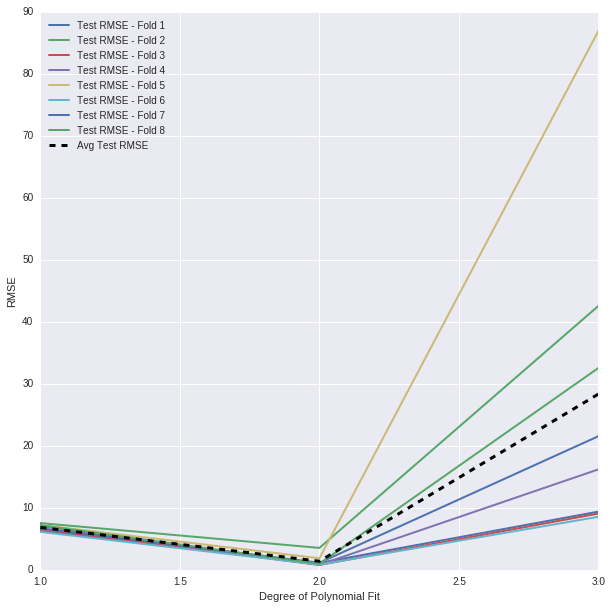

In [12]:
# Plot la courbe d'erreur k-fold CV set
folds = 8
degrees = 3
kf_dict = k_fold_cross_val_poly(folds, degrees, X, y)
plot_test_error_curves_kf(kf_dict, folds, degrees)

In [13]:
print('Le régresseur polynomial atteint une valeur moyenne minimale RMSE : %s pour un degré %s'
      %(kf_dict['avg'].min(),kf_dict['avg'].argmin()+1))

Le régresseur polynomial atteint une valeur moyenne minimale RMSE : 1.37977908752 pour un degré 2


- > *** Intreprétation: on décide de choisir un degré polynomial de 2. ***

In [14]:
# Sélection du model:

lr = LinearRegression() #init
polynomial_features = PolynomialFeatures(degree=2, include_bias=False)
# Création du pipeline
pipe = Pipeline([("polynomial_features", polynomial_features),
        ("linear_regression", lr)])
grid = dict(linear_regression__normalize=[False,True]) #espace de paramètre de la régression
                                                        # choix sur la normalisation
model = GridSearchCV(pipe,param_grid=grid,cv=8)
model.fit(X0_train, y0_train)
#predict
y_lr = model.predict(X0_test)

In [15]:
#Evaluation du modèle :
print("L'erreur type (RMSE) est de %s") %(RMSE(y0_test, y_lr))
print("La moyenne absolue de pourcentage d'erreur est de %s %%") %(mape_error(y0_test, y_lr))
print("Meilleur model utilisant %s." % ( model.best_params_))

L'erreur type (RMSE) est de 1.41974719471
La moyenne absolue de pourcentage d'erreur est de 13.7868232122 %
Meilleur model utilisant {'linear_regression__normalize': False}.


***Nous obtenons un pourcentage d'erreur d'environ 14 % et une RMSE de 1.41 légèrement sous performé (vis à vis de 1.39 un peu plus haut), car dans cette dernière mesure j'ai décidé de restreindre l'apprentissage sur X0_train et tester sur X0_test. C'est correct, mais nous ne pouvons pas pour autant nous en contenter, car nous pouvons faire mieux. C'est ce que nous allons voir dans la suite de ce Notebook.***

- ## A-bis. Méthode Linéaire Lasso  
    - Approche polynomiale et cross validation

In [16]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

(0.0001, 0.31622776601683794)

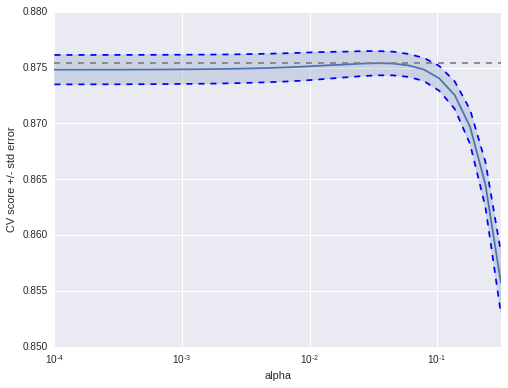

In [17]:
lasso = Lasso(random_state=42)
alphas = np.logspace(-4, -0.5, 30)

scores = list()
scores_std = list()

n_folds = 3

for alpha in alphas:
    lasso.alpha = alpha
    this_scores = cross_val_score(lasso, X, y, cv=n_folds, n_jobs=1)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

scores, scores_std = np.array(scores), np.array(scores_std)

plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

/home/duc-vinh/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


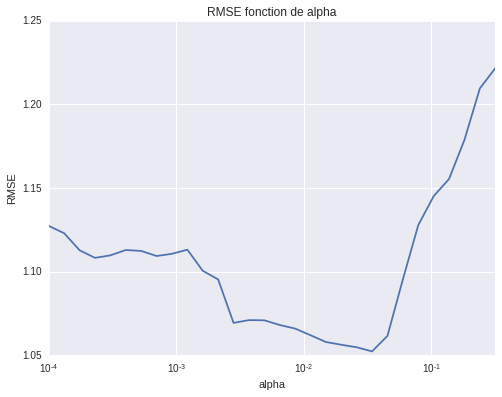

In [18]:
lasso = Lasso(random_state=42)
alphas = np.logspace(-4, -0.5, 30)

#feature polynomial d'ordre 2
polynomial_features = PolynomialFeatures(degree=2, include_bias=False)
X0_train_ = polynomial_features.fit_transform(X0_train)
X0_test_ = polynomial_features.fit_transform(X0_test)

#list
rmse = list()
MAPE = list()

n_folds = 3

for alpha in alphas:
    lasso.alpha = alpha
    lasso.fit(X0_train_,y0_train)
    y_lr=lasso.predict(X0_test_)
    rmse.append(RMSE(y0_test, y_lr))
    MAPE.append(mape_error(y0_test, y_lr))
rmse, MAPE = np.array(rmse), np.array(MAPE)

plt.figure().set_size_inches(8, 6)


# plot error lines showing +/- std. errors of the scores

plt.semilogx(alphas, rmse)
#plt.semilogx(alphas, MAPE)

# alpha=0.2 controls the translucency of the fill color

plt.ylabel('RMSE')
plt.xlabel('alpha')
plt.xlim([alphas[0], alphas[-1]])
plt.title('RMSE fonction de alpha')

In [19]:
#alphas qui minimise la RMSE:
alpha=alphas[rmse.argmin()]
#fit avec cet alpha

In [20]:
#Evaluation du modèle :
print("L'erreur type (RMSE) est de %s") %((rmse.min()))
print("La moyenne absolue de pourcentage d'erreur est de %s %%") %(MAPE[rmse.argmin()])
print("Meilleur model utilisant alpha = %s." % (alpha))

L'erreur type (RMSE) est de 1.05245632263
La moyenne absolue de pourcentage d'erreur est de 10.989615688 %
Meilleur model utilisant alpha = 0.0342359795761.


- > ***Interprétation : on obtient des résultats remarquables avec la régression lasso sur donnée polynomiale d'ordre 2.***

- ## B. Méthode par plus proche voisin

In [21]:
from sklearn.neighbors import KNeighborsRegressor
knn=KNeighborsRegressor()

n_neighbors=[2,3,5,7,12,15,20,30,40,50,60,100]
leaf_size=[10,20,30,40,50]
param_grid = dict(n_neighbors=n_neighbors, leaf_size=leaf_size)

model = GridSearchCV(knn, param_grid, n_jobs=-1, cv=10,scoring='neg_mean_squared_error') #neg_mean_squared_error pour
                                                                                        #sklearn > 0.18
model.fit(X0_train, y0_train)

#Prédiction:
y_knn = model.predict(X0_test)
print("L'erreur type (RMSE) est de %s") %(RMSE(y0_test, y_knn))
print("La moyenne absolue de pourcentage d'erreur est de %s %%") %(mape_error(y0_test, y_knn))
print("Meilleur model utilisant %s." % ( model.best_params_))

L'erreur type (RMSE) est de 19.8156530185
La moyenne absolue de pourcentage d'erreur est de 324.051607628 %
Meilleur model utilisant {'n_neighbors': 100, 'leaf_size': 10}.


- > ***Interprétations : cette méthode est à ignorer...***

- ## C. Méthodes non-linéaires : méthodes ensemblistes  <a name="ensemblistes"></a>

***Ici, nous allons faire usage de méthodes non-linéaires d'apprentissage automatique, et nous verrons quelle est la meilleure méthode en termes de performances (notamment en termes de taux d'erreur et de vitesse d'exécution).***

In [22]:
from sklearn.ensemble import RandomForestRegressor, RandomForestRegressor, GradientBoostingRegressor 
from sklearn.cross_validation import KFold
from sklearn.externals import joblib
#from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb

***Commençons par tester la méthode de régression des fôrets aléatoires.***  <a name="RF"></a>

In [23]:
%%time
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=300, max_depth=7, n_jobs=-1, max_features=None,criterion='mse',
                               min_samples_split=5,random_state=42)
rf.fit(X0_train, y0_train)
y_rf = rf.predict(X0_test)
print("L'erreur type (RMSE) est de %s") %(RMSE(y0_test, y_rf))
print("La moyenne absolue de pourcentage d'erreur est de %s %%") %(mape_error(y0_test, y_rf))

L'erreur type (RMSE) est de 3.7329847872
La moyenne absolue de pourcentage d'erreur est de 65.0436968742 %
CPU times: user 1.7 s, sys: 96 ms, total: 1.79 s
Wall time: 1.08 s


- > ***Interprétations : résultats vraiment décevants, on va chercher à tuner un peu le model.***

- **GridSearch et Cross Validation**

In [24]:
%%time
rf = RandomForestRegressor(criterion='mse', max_features=None,random_state=42)
n_estimators = [50, 100, 150, 200,300,400]
max_depth = [2, 4, 6, 8,10]
min_samples_split=[2,4,6,8]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators, min_samples_split=min_samples_split)
model = GridSearchCV(rf, param_grid, n_jobs=-1, cv=10,scoring='neg_mean_squared_error') #neg_mean_squared_error pour
                                                                                        #sklearn > 0.18
model.fit(X0_train, y0_train)
y_rf = model.predict(X0_test)
print("L'erreur type (RMSE) est de %s") %(RMSE(y0_test, y_rf))
print("La moyenne absolue de pourcentage d'erreur est de %s %%") %(mape_error(y0_test, y_rf))

L'erreur type (RMSE) est de 3.3937268745
La moyenne absolue de pourcentage d'erreur est de 52.9839799078 %
CPU times: user 8.09 s, sys: 248 ms, total: 8.34 s
Wall time: 3min 54s


In [25]:
print("Meilleur model utilisant %s." % ( model.best_params_))

Meilleur model utilisant {'min_samples_split': 2, 'n_estimators': 300, 'max_depth': 10}.


- > ***Nous obtenons une MAPE d'environ 53 % et un RMSE de 3.4. C'est légèrement mieux, mais encore une fois cela reste horrible.***

***Cette fois, testons toujours la méthode de régression extra-trees, mais cette fois, avec un nombre d'estimateurs plus important (porté à 300), et une profondeur maximale bien plus réduite (profondeur maximale de 7).***

In [26]:
%%time
from sklearn.ensemble import ExtraTreesRegressor

et = ExtraTreesRegressor(n_estimators=300, criterion='mse',max_depth=7,n_jobs=-1,
                         min_samples_split=5,max_features=None)
et.fit(X0_train, y0_train)
y_et = et.predict(X0_test)
print("L'erreur type (RMSE) est de %s") %(RMSE(y0_test, y_et))
print("La moyenne absolue de pourcentage d'erreur est de %s %%") %(mape_error(y0_test, y_et))

L'erreur type (RMSE) est de 3.75008271171
La moyenne absolue de pourcentage d'erreur est de 49.5169906785 %
CPU times: user 1.08 s, sys: 100 ms, total: 1.18 s
Wall time: 963 ms


- **GridSearch et Cross Validation**

In [27]:
%%time
et = ExtraTreesRegressor(criterion='mse',max_features=None)
n_estimators = [100, 150, 200,300,400]
max_depth = [4, 6, 8,10]
min_samples_split=[2,4,6,8]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators, min_samples_split=min_samples_split)
model = GridSearchCV(et, param_grid, n_jobs=-1, cv=10,scoring='neg_mean_squared_error')
model.fit(X0_train, y0_train)
y_et = model.predict(X0_test)
print("L'erreur type (RMSE) est de %s") %(RMSE(y0_test, y_et))
print("La moyenne absolue de pourcentage d'erreur est de %s %%") %(mape_error(y0_test, y_et))

L'erreur type (RMSE) est de 3.02543015481
La moyenne absolue de pourcentage d'erreur est de 40.8388633839 %
CPU times: user 4.98 s, sys: 88 ms, total: 5.07 s
Wall time: 2min 36s


In [28]:
print("Meilleur model utilisant %s." % ( model.best_params_))

Meilleur model utilisant {'min_samples_split': 2, 'n_estimators': 100, 'max_depth': 10}.


- > ***Nous obtenons une MAPE d'environ 40 %. L'erreur est meilleure (entendre "plus faible") lorsque la profondeur est importante, mais que le nombre d'estimateurs n'est pas colossal, néanmoins une grande profondeur tend à overfitter.***

***Pour le XG Boost: ***<a name="XGB"></a>

In [29]:
%%time
xg = xgb.XGBRegressor(max_depth=3, n_estimators=300, learning_rate=0.05).fit(X0_train, y0_train)
y_xgb = xg.predict(X0_test)
print("L'erreur type (RMSE) est de %s") %(RMSE(y0_test, y_xgb))
print("La moyenne absolue de pourcentage d'erreur est de %s %%") %(mape_error(y0_test, y_xgb))

L'erreur type (RMSE) est de 3.25508904849
La moyenne absolue de pourcentage d'erreur est de 26.7343848353 %
CPU times: user 952 ms, sys: 0 ns, total: 952 ms
Wall time: 140 ms


- > ***Nous obtenons un pourcentage d'erreur d'environ 34 % et une MSE de 2.8. C'est un progrès net. Le modèle XGBoost semble une piste à creuser.***

In [30]:
%%time
xg = xgb.XGBRegressor(seed=42,nthread=-1)
n_estimators = [100, 150, 200,300,400]
max_depth = [3,4, 6, 8,10]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)
model = GridSearchCV(xg, param_grid, cv=10,scoring='neg_mean_squared_error') # n_jobs=-1,
model.fit(X0_train, y0_train)
y_xgb = model.predict(X0_test)
print("L'erreur type (RMSE) est de %s") %(RMSE(y0_test, y_xgb))
print("La moyenne absolue de pourcentage d'erreur est de %s %%") %(mape_error(y0_test, y_xgb))

L'erreur type (RMSE) est de 2.60610232787
La moyenne absolue de pourcentage d'erreur est de 31.5348555556 %
CPU times: user 4min 14s, sys: 784 ms, total: 4min 14s
Wall time: 34.8 s


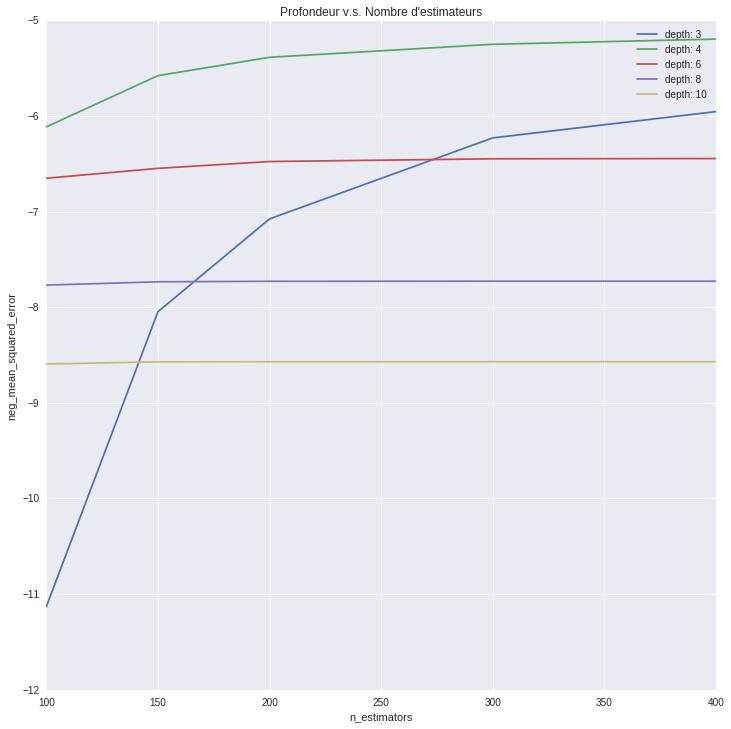

In [31]:
means = model.cv_results_['mean_test_score']
stds = model.cv_results_['std_test_score']
params = model.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param))
# plot results
plt.figure(figsize = (12,12))
scores = np.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
    plt.plot(n_estimators, scores[i], label='depth: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('neg_mean_squared_error')
plt.title("Profondeur v.s. Nombre d'estimateurs")

In [32]:
%%time
xg = xgb.XGBRegressor(seed=42,nthread=-1)
n_estimators = [100, 150, 200,300,400]
max_depth = [3,4, 6, 8,10]
learning_rate=[0.05,0.075]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators,learning_rate=learning_rate)
model = GridSearchCV(xg, param_grid, cv=10,scoring='neg_mean_squared_error') # n_jobs=-1,
model.fit(X0_train, y0_train)
y_xgb = model.predict(X0_test)
print("L'erreur type (RMSE) est de %s") %(RMSE(y0_test, y_xgb))
print("La moyenne absolue de pourcentage d'erreur est de %s %%") %(mape_error(y0_test, y_xgb))

L'erreur type (RMSE) est de 2.64332505414
La moyenne absolue de pourcentage d'erreur est de 31.791561918 %
CPU times: user 7min 54s, sys: 1.59 s, total: 7min 55s
Wall time: 1min 4s


<font color='red'>**WARNING : **</font> 

** Le compilateur gcc est nettement moins performant sous Macintosh:**
    - > 8min13 (12 coeurs, Mac) vs 54s (8 coeurs, Linux)

In [33]:
print("Meilleur model utilisant %s." % ( model.best_params_))

Meilleur model utilisant {'n_estimators': 400, 'learning_rate': 0.075, 'max_depth': 4}.


- > ***Nous obtenons une MAPE d'environ 32 % mais un RMSE des plus faibles avec 2.64. C'est très légèrement moins bien que la régression linéaire que l'on a sélectionné plus haut (degré polynomial 2, cv10 et sans normalisation).***

**Test du XGBoost avec des features polynomiales :**

L'intuition voudrait que le fait de dériver des features polynomiales à partir de la donnée brute soit innéficace pour les méthodes de types ensemblistes.

In [34]:
%%time
xg = xgb.XGBRegressor(seed=42,nthread=-1)

#feature polynomial d'ordre 2
polynomial_features = PolynomialFeatures(degree=2, include_bias=False)
X0_train_ = polynomial_features.fit_transform(X0_train)
X0_test_ = polynomial_features.fit_transform(X0_test)

#param
n_estimators = [100, 150, 200,300,400]
max_depth = [3,4, 6, 8,10]
learning_rate=[0.05,0.075]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators,learning_rate=learning_rate)

#GridsearchCV
model = GridSearchCV(xg, param_grid, cv=10,scoring='neg_mean_squared_error') # n_jobs=-1,
model.fit(X0_train_, y0_train)
y_xgb = model.predict(X0_test_)

print("L'erreur type (RMSE) est de %s") %(RMSE(y0_test, y_xgb))
print("La moyenne absolue de pourcentage d'erreur est de %s %%") %(mape_error(y0_test, y_xgb))
print("Meilleur model utilisant %s." % ( model.best_params_))

L'erreur type (RMSE) est de 2.69024945998
La moyenne absolue de pourcentage d'erreur est de 23.4265950045 %
Meilleur model utilisant {'n_estimators': 400, 'learning_rate': 0.05, 'max_depth': 4}.
CPU times: user 37min 30s, sys: 2.43 s, total: 37min 32s
Wall time: 4min 47s


- > *** Interprétation : notre intuition s'est révélée être correcte, dériver des features polynomiales n'apportent rien au modèle ensembliste.***

# Visualisation de l'arbre de décision

# III. Evaluation des modèles retenus  <a name="interprétation"></a>

** On étudie les deux modèles aux plus grande performances**

- - ### Modèle Linéaire simple :

In [35]:
#interprétations des coéfficients
def pretty_print_linear(coefs, names = None, sort = False,filter_=True,threshold=0.005):
    if names == None:
        names = ["X%s" % x for x in range(len(coefs))]
    lst = zip(coefs, names)
    if sort:
        lst = sorted(lst,  key = lambda x:-np.abs(x[0]))
    
    df=pd.DataFrame()
    df['coef'],df['var'] = map(list, zip(*lst))
    if filter_:
        df = df[abs(df['coef'])>threshold]
        df.reset_index(inplace=True,drop=True)
    return df
 


In [36]:
#Reprise du modèle linéaire
lr = LinearRegression() #init
polynomial_features = PolynomialFeatures(degree=2, include_bias=False)
X_ = polynomial_features.fit_transform(X)
#X0_test_ = polynomial_features.fit_transform(X0_test)

#grid = dict(linear_regression__normalize=[False,True]) #espace de paramètre de la régression
                                                        # choix sur la normalisation
#model = GridSearchCV(pipe,param_grid=grid,cv=8)
lr.fit(X_, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [37]:
#Reconstruire le tableau avec le nom des variables
target_feature_names = ['x'.join(['{}^{}'.format(pair[0],pair[1]) for pair in tuple if pair[1]!=0]) for tuple in [zip(X.columns,p) for p in polynomial_features.powers_]]
output_df = pd.DataFrame(X_, columns = target_feature_names)

In [38]:
print "Linear model:"
pretty_print_linear(lr.coef_,names = list(output_df.columns),sort=True,threshold=0.01)

Linear model:


,coef,var
0,1.808535,Categorie socio professionnelle_Sans emploi^2
1,1.808535,Categorie socio professionnelle_Sans emploi^1
2,1.351918,Categorie socio professionnelle_Etudiant^1
3,1.351918,Categorie socio professionnelle_Etudiant^2
4,1.117582,Marque_Toyota^1xType de vehicule_Utilitaire^1
5,-0.963542,Categorie socio professionnelle_Ouvrier^1
6,-0.963542,Categorie socio professionnelle_Ouvrier^2
7,0.925964,Marque_Toyota^1xType de vehicule_SUV^1
8,0.821406,Marque_Renault^1xType de vehicule_Utilitaire^1
9,0.804205,Categorie socio professionnelle_Etudiant^1xMar...


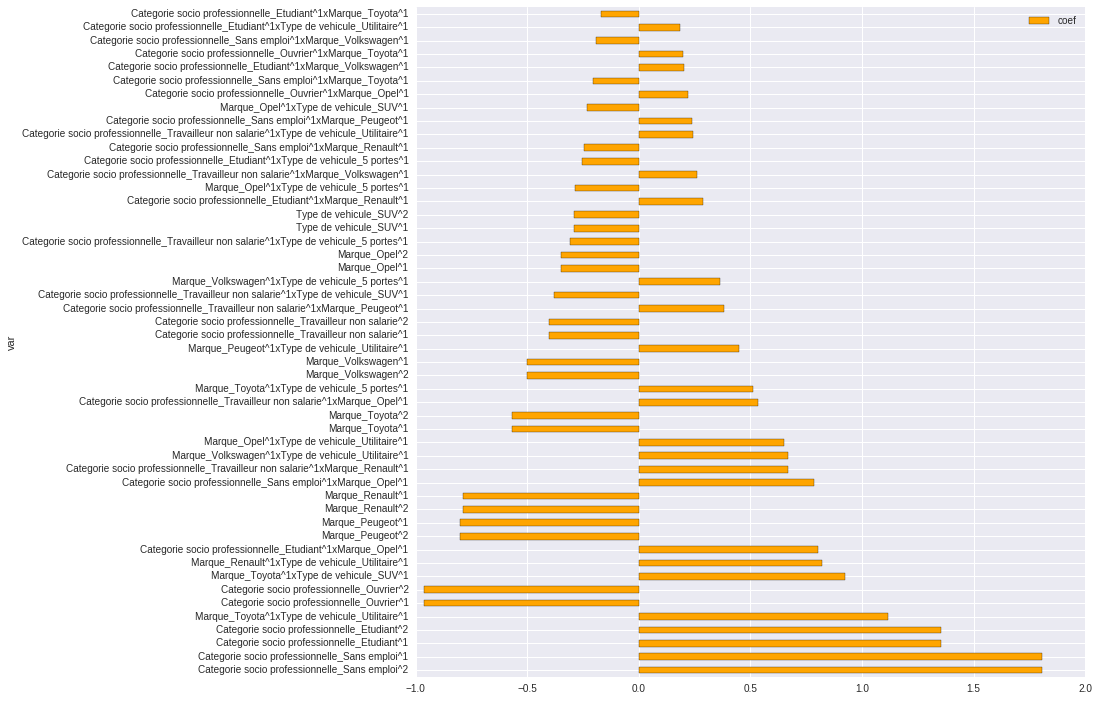

In [39]:
importance_frame = pretty_print_linear(lr.coef_,names = list(output_df.columns),sort=True,threshold=0.01)
#importance_frame.sort_values(by = 'Importance', inplace = True)
importance_frame[0:50].plot(kind = 'barh', x = 'var', figsize = (12,12), color = 'orange')

- > ***La lecture des coefficients est peu satisfante***

- - ### Modèle linéaire Lasso

In [40]:
lasso = Lasso(random_state=42)
alphas = np.logspace(-4, -0.5, 30)

rmse = list()
MAPE = list()
lr = list()

n_folds = 3

for alpha in alphas:
    lasso.alpha = alpha
    lasso.fit(X0_train_,y0_train)
    lr.append(lasso)
    y_lr=lasso.predict(X0_test_)
    rmse.append(RMSE(y0_test, y_lr))
    MAPE.append(mape_error(y0_test, y_lr))
rmse, MAPE = np.array(rmse), np.array(MAPE)

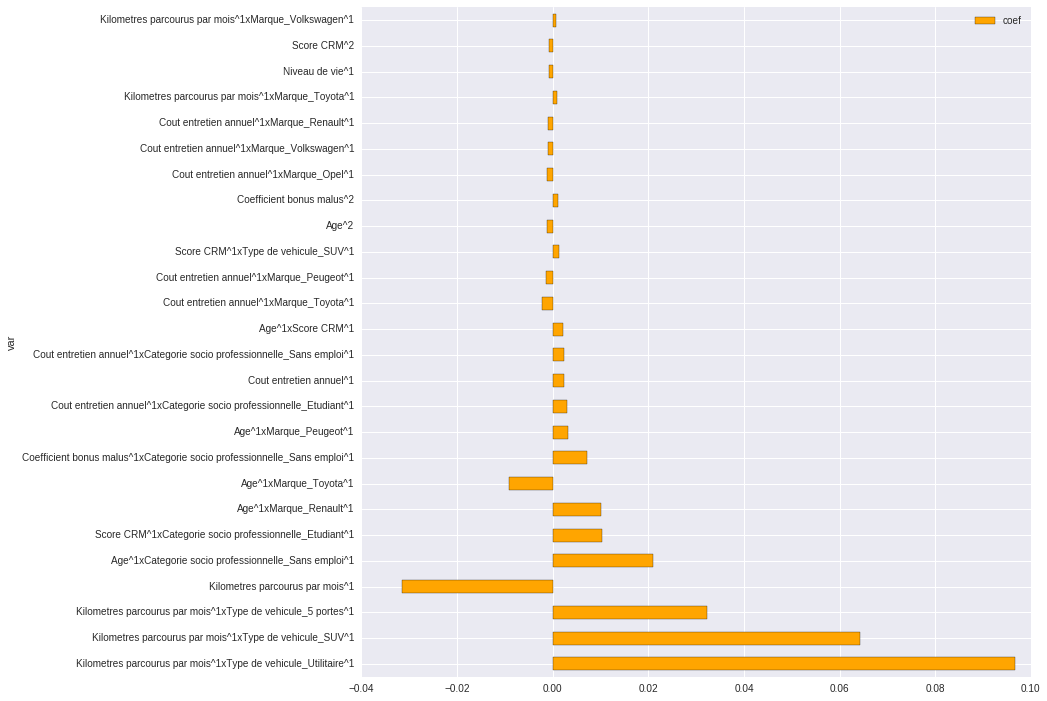

In [41]:
#alphas qui minimise la RMSE:
alpha=alphas[rmse.argmin()]
#Evaluation du modèle :
best_regressor = lr[rmse.argmin()]

importance_frame = pretty_print_linear(best_regressor.coef_,names = list(output_df.columns),sort=True,threshold=0.0006)
#importance_frame.sort_values(by = 'Importance', inplace = True)
importance_frame[0:50].plot(kind = 'barh', x = 'var', figsize = (12,12), color = 'orange')

- > ***La lecture des coefficients est bien plus satisfaisante avec la régression Lasso, les interprétations à valeurs métiers ont ici un sens.***

- - ### Modèle XGBoost :

- ## Plot des features selon leur importance

***Dans cette étape d'évaluation du modèle, nous allons représenter sous la forme d'un diagramme horizontal les variables qui contribuent le plus au modèle, à l'aide de la méthode XGBoost.***

In [42]:
%%time
dtrain = xgb.DMatrix(X0_train,label=y0_train)
dtest = xgb.DMatrix(X0_test)

params = {'booster':'gbtree', 'eta':0.2, 'max_depth':4, 'subsample':0.8, 'n_estimators':400,
                 'silent':1, 'objective':'reg:linear', "seed":42, 'nhtread':12,
                 'eval_metric':'rmse','colsample_bytree':0.7}
    
xg = xgb.train(params, dtrain, 400)
y_xg = xg.predict(dtest)
print("L'erreur type (RMSE) est de %s") %(RMSE(y0_test, y_xg))
print("La moyenne absolue de pourcentage d'erreur est de %s %%") %(mape_error(y0_test, y_xg))

L'erreur type (RMSE) est de 3.47403425125
La moyenne absolue de pourcentage d'erreur est de 21.892332683 %
CPU times: user 1.19 s, sys: 8 ms, total: 1.2 s
Wall time: 163 ms


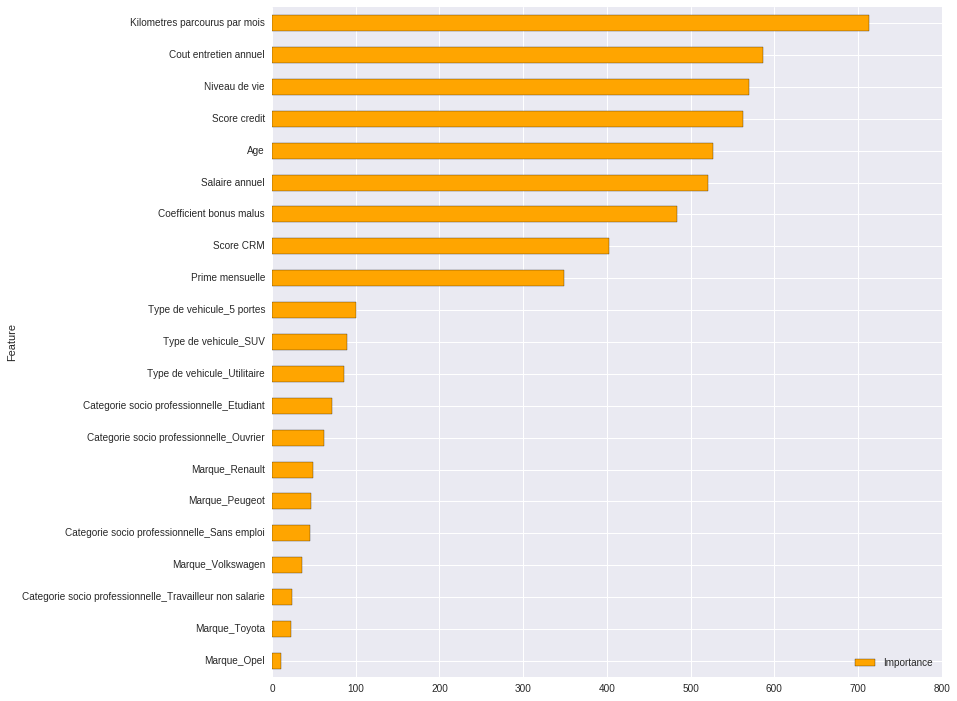

In [43]:
importances = xg.get_score()
importance_frame = pd.DataFrame({'Importance': list(importances.values()),'Feature': list(importances.keys())})
importance_frame.sort_values(by = 'Importance', inplace = True)
importance_frame[0:75].plot(kind = 'barh', x = 'Feature', figsize = (12,12), color = 'orange')

- > ***L'importances des features pour le modèle XGBoost semblent être en adéquation avec le sens métier qu'elles apportent au calcul du bénifice net annuel. En effet, on peut interpréter :***
    - Le kilométrage influe sur le risque / proba d'accidents
    - Coût d'entretient est directement lié au bénéfice net annuel étant donné que plus la voiture est coûteuse à entretenir / réparer plus cela impactera le calcul de bénéfice (soit augmentation de la prime d'assurance, soit coût de l'assureur à réparer en cas d'accidents)
    - etc...

# IV. Soumission des résultats  <a name="submit"></a>

In [44]:
path='../models/Approche Naive/'

In [45]:
def write_to_file(X_prod,y_pred,name_file,path) :
    if not os.path.exists(path):
        os.makedirs(path)
    X_prod['Benefice net annuel predit'] = y_pred
    X_prod[['Benefice net annuel predit']].to_csv(path+name_file, index=True, sep='|')
    print('Ecriture finie.')
    return

In [46]:
%%time
#Application aux données de Test pour soumission
xg = xgb.XGBRegressor(seed=42,nthread=-1)
n_estimators = [100, 150, 200,300,400]
max_depth = [3,4, 6, 8,10]
learning_rate=[0.05,0.075]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators,learning_rate=learning_rate)
model = GridSearchCV(xg, param_grid, cv=10,scoring='neg_mean_squared_error') # n_jobs=-1,
model.fit(X, y)
y_xgb = model.predict(T)
print("Meilleur model utilisant %s." % ( model.best_params_))

#Ecriture
write_to_file(T.copy(), y_xgb,'ma_prediction_XGB.csv',path)

Meilleur model utilisant {'n_estimators': 400, 'learning_rate': 0.075, 'max_depth': 4}.
Ecriture finie.
CPU times: user 8min 10s, sys: 1.58 s, total: 8min 12s
Wall time: 1min 4s


In [47]:
%%time
lr = LinearRegression() #init
polynomial_features = PolynomialFeatures(degree=2, include_bias=False)
# Création du pipeline
pipe = Pipeline([("polynomial_features", polynomial_features),
        ("linear_regression", lr)])
grid = dict(linear_regression__normalize=[False,True]) #espace de paramètre de la régression
                                                        # choix sur la normalisation
model = GridSearchCV(pipe,param_grid=grid,cv=8)
model.fit(X, y)
#predict
y_lr = model.predict(T)
write_to_file(T.copy(), y_lr,'ma_prediction_RL.csv',path)

Ecriture finie.
CPU times: user 1.91 s, sys: 4.37 s, total: 6.28 s
Wall time: 802 ms
